<a href="https://colab.research.google.com/github/withpi/cookbook-withpi/blob/main/workshop/Building_Evals_that_actually_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://withpi.ai"><img src="https://withpi.ai/logo/logoFullBlack.svg" width="240"></a>

<a href="https://code.withpi.ai"><font size="4">Documentation</font></a>

<a href="https://withpi.ai"><font size="4">Copilot</font></a>

# [Workshop] Building Evals that actually work

In this Notebook you will learn how to leverage Pi's scoring system offline (e.g. model comparison) and online (e.g. rejection sampling).

At this point you have already built a scoring system and tested it in a spreadsheet. In this notebook we will do the following:

1.   Initialize Pi SDK
2.   Initialize the Scoring system
3.   Evaluate a Hugging Face dataset (this is the same data we evaluated in sheets)
4.   Compare Models. By default it compares two Gemini models, but feel free to compare your favorite models.
5.   Test system prompt variations
6.   Try Rejection Sampling. Here you are asking your LLM to generate multiple responses for a single input and then picking the best one. By varying the number of samples from 1-n you can see how the score and quality of output increases.



## Install and initialize SDK

You'll need a `WITHPI_API_KEY` from https://withpi.ai/account/keys.  Add it to your notebook secrets (the key symbol) on the left.

Run the cell below to install packages and load the SDK

In [4]:
%%capture

%pip install withpi withpi-utils litellm
# See https://github.com/huggingface/datasets/issues/7570
%pip install -U datasets huggingface_hub fsspec

import os
from google.colab import userdata
from withpi import PiClient

# Load the notebook secret into the environment so the Pi Client can access it.
os.environ["WITHPI_API_KEY"] = userdata.get('WITHPI_API_KEY')

pi = PiClient()

## Setup scoring system

From your Copilot session with your scoring system, click `Code`, and then copy the contents of that cell.  Paste it below, overwriting the example spec.  This will define a `score()` function that the rest of the Colab will refer to.

In [5]:
from withpi import PiClient

# Initialize Pi client
pi = PiClient()

def score(llm_input, llm_output)->float:
  scoring_spec =   [
    {
      "label": "Title Accuracy",
      "question": "Does the output include an accurate and relevant title summarizing the transcript?",
      "weight": 0.5
    },
    {
      "label": "Key Insights",
      "question": "Does the output extract all major insights from the transcript?",
      "weight": 0.5
    },
    {
      "label": "Action Items",
      "question": "Are all action items mentioned in the transcript included in the output?",
      "weight": 0.5
    },
    {
      "label": "Action Details",
      "question": "Does the output provide optional details like owner and due date for action items when available?",
      "weight": 0.5
    },
    {
      "label": "JSON Format",
      "question": "Is the output structured correctly in JSON format, including when embedded in Markdown code blocks?",
      "python_code": "from typing import Any\n\n\ndef score(\n    response_text: str,\n    input_text: str,\n    kwargs: dict[str, Any],\n) -> dict:\n    def evaluate_response(response):\n        \"\"\"\n        Check if the response contains valid JSON, including when embedded in Markdown code blocks.\n\n        Args:\n            response (str): The LLM's response text\n\n        Returns:\n            float: 1.0 if valid JSON is found (standalone or in Markdown), 0.0 otherwise\n        \"\"\"\n        import json\n\n        try:\n            parsed = json.loads(\n                response.strip().removeprefix(\"```json\").removesuffix(\"```\").strip()\n            )\n\n        except json.JSONDecodeError:\n            return 0.0\n\n        return 1.0\n\n    final_score = evaluate_response(response_text)\n    return {\"score\": final_score, \"explanation\": \"\"}\n",
      "scoring_type": "PYTHON_CODE",
      "weight": 0.5
    },
    {
      "label": "Transcript Coverage",
      "question": "Does the output cover all relevant sections of the transcript without omitting critical information?",
      "weight": 0.3
    },
    {
      "label": "Insight Clarity",
      "question": "Are the key insights presented in a clear and concise manner?",
      "weight": 0.3
    },
    {
      "label": "Action Completeness",
      "question": "Does each action item include sufficient details to be actionable?",
      "weight": 0.3
    },
    {
      "label": "Owner Identification",
      "question": "Does the output correctly identify the owner for each action item when specified in the transcript?",
      "weight": 0.3
    },
    {
      "label": "Due Date Inclusion",
      "question": "Does the output include due dates for action items when specified in the transcript?",
      "weight": 0.3
    },
    {
      "label": "Redundancy Avoidance",
      "question": "Does the output avoid redundant or repetitive information?",
      "weight": 0.1
    },
    {
      "label": "Abusive Language",
      "question": "Does the output avoid using abusive or inappropriate language?",
      "weight": 0.1
    }
  ]

  return pi.scoring_system.score(llm_input=llm_input, llm_output=llm_output, scoring_spec=scoring_spec).total_score


## Evaluate a dataset

Load rated data from Hugging Face to evaluate.  This is the same data as was in the Sheets. This is to demonstrate that you can do the same evaluation in Python.

In [ ]:
from datasets import load_dataset
import pandas as pd

example_ds = load_dataset("withpi/aiewf_workshop_data")['train']

def score_example(example):
  example["Score"] = score(example["Raw meeting transcript"], example["Extracted output"])
  example["Predicted Rating"] = "thumbs_up" if example["Score"] > 0.6 else "thumbs_down"
  return example

scored = example_ds.map(score_example)
df = pd.DataFrame(scored)
display(df)

Dataset({
    features: ['Rating', 'Raw meeting transcript', 'Extracted output'],
    num_rows: 126
})

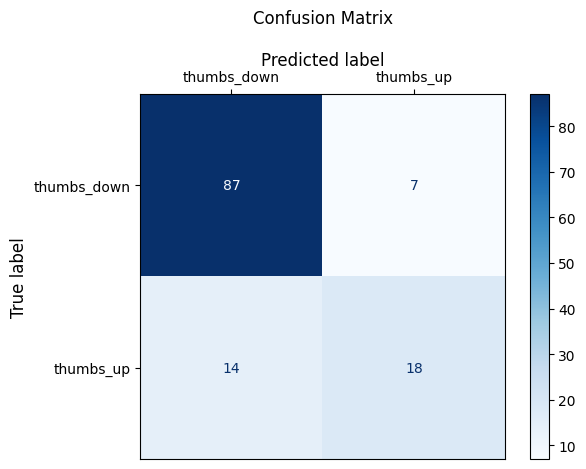

In [ ]:
# @title Create a confusion matrix that shows the alignment between true ratings and Pi score's predicted ratings

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def plot_confusion_matrix_from_df(df: pd.DataFrame, true_col='Rating', pred_col='Predicted Rating', labels=None):
    """
    Plots a confusion matrix with predicted ratings on top.
    """
    y_true = df[true_col]
    y_pred = df[pred_col]

    # Automatically determine label order if not provided
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots()
    disp.plot(cmap="Blues", ax=ax, colorbar=True)

    # Move x-axis label (predicted) to the top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_title("Confusion Matrix", pad=20)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_from_df(df)

## Compare Models

Now that you have a scoring system, let's try a few different models to more objectively compare how they do.

We have a dataset of longer meeting transcripts that are somewhat more confusing than average.  Let's see how a couple of different models do.

You can import a Google Gemini key from AI Studio on the left pane, which populates a `GOOGLE_API_KEY` secret.  At low rates it's free.  Or adjust to a model of your choice with a key using docs at https://docs.litellm.ai/docs/.

In [9]:
from datasets import load_dataset
import litellm
from concurrent.futures import as_completed, ThreadPoolExecutor

ds = load_dataset("withpi/aiewf_workshop_data_extra_long_transcripts")

system_prompt = """
You are an AI assistant designed to analyze meeting or conversation transcripts. Given a transcript, your task is to extract the following elements and return them in **JSON format**:

1. **Title**: A concise and informative title summarizing the main topic or purpose of the conversation.
2. **Key Insights**: A list of the most important insights, takeaways, or conclusions drawn from the transcript. Each insight should be clear, standalone, and phrased in natural language.
3. **Action Items**: A list of actionable tasks or follow-ups mentioned or implied in the conversation. Include who is responsible (if mentioned), what the action is, and any relevant deadlines or context.

### JSON Output Format:

json
{
  "title": "string",
  "key_insights": [
    "string",
    "string"
  ],
  "action_items": [
    {
      "description": "string",
      "owner": "string (optional)",
      "due_date": "string (optional)"
    }
  ]
}



### Guidelines:

Do not include any information not found in or inferred directly from the transcript.
Be concise and clear in phrasing each output field.
"""

os.environ["GEMINI_API_KEY"] = userdata.get('GOOGLE_API_KEY')
#os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
#os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

def generate_and_score(model, rows):
  def process_row(transcript):
    generated = litellm.completion(
      model=model,
      messages=[
          {"content": system_prompt, "role": "system"},
          {"content": transcript, "role": "user"}
      ]).choices[0].message.content
    computed_score = score(transcript, generated)
    return {
        "generated": generated,
        "computed_score": computed_score
    }
    return row
  with ThreadPoolExecutor(max_workers=4) as executor:
    responses = [executor.submit(process_row, transcript) for transcript in rows["Raw meeting transcript"]]
  return {
      f"{model} Extracted output": [res.result()["generated"] for res in responses],
      f"{model} Score": [res.result()["computed_score"] for res in responses],
  }

more_models = ds['train'].select(range(10)).map(lambda row: generate_and_score("gemini/gemini-2.5-flash-preview-05-20", row), batched=True, batch_size=4)
more_models = more_models.select(range(10)).map(lambda row: generate_and_score("gemini/gemini-1.5-flash", row), batched=True, batch_size=4)
#more_models = more_models.select(range(10)).map(lambda row: generate_and_score("openai/gpt-4.1-nano", row), batched=True, batch_size=4)
#more_models = more_models.select(range(10)).map(lambda row: generate_and_score("anthropic/claude-3-haiku-20240307", row), batched=True, batch_size=4)

df = pd.DataFrame(more_models)

print(f"Average score for Gemini 2.5 flash: {df['gemini/gemini-2.5-flash-preview-05-20 Score'].mean():.3f}")
print(f"Average score for Gemini 1.5 flash: {df['gemini/gemini-1.5-flash Score'].mean():.3f}")
##print(f"Average score for OpenAI GPT 4.1 nano: {df['openai/gpt-4.1-nano Score'].mean():.3f}")
##print(f"Average score for Claude Haiku 3: {df['anthropic/claude-3-haiku-20240307 Score'].mean():.3f}")

display(df[['Raw meeting transcript','gemini/gemini-2.5-flash-preview-05-20 Score','gemini/gemini-1.5-flash Score']])
# display(df[['Raw meeting transcript','gemini/gemini-2.5-flash-preview-05-20 Score','gemini/gemini-1.5-flash Score','openai/gpt-4.1-nano Score', 'anthropic/claude-3-haiku-20240307 Score']])


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Average score for Gemini 2.5 flash: 0.921
Average score for Gemini 1.5 flash: 0.824


,Raw meeting transcript,gemini/gemini-2.5-flash-preview-05-20 Score,gemini/gemini-1.5-flash Score
0,Speaker 0: Ten Eyes Cancer build 20 1-659 has ...,0.9325,0.9457
1,"Speaker 1: Thank you. Thank you, Miss Butler. ...",0.8813,0.5226
2,Speaker 0: Motion case.\nSpeaker 1: Thank you....,0.8884,0.8879
3,Speaker 1: Thank you very much. Moving on to t...,0.8398,0.8595
4,"Speaker 2: Motion carries, we'll.\nSpeaker 1: ...",0.9646,0.8930
5,Speaker 0: Motion carry.\nSpeaker 6: Annexes. ...,0.9492,0.9057
6,"Speaker 3: Therefore, I very respectfully ask ...",0.9238,0.8443
7,Speaker 0: So I won't need to get those done f...,0.9551,0.9343
8,Speaker 1: Communication from Mayor Garcia rec...,0.9016,0.8926
9,"Speaker 3: Councilwoman Kanis, will you please...",0.9726,0.5532


## Test system prompts

Here you will try multiple system prompts and see how the score changes as a result. By default there are two prompts, a simple one and a more comprehensive prompt.

In [12]:
import litellm
from datasets import Dataset
from tqdm.notebook import tqdm
from concurrent.futures import as_completed, ThreadPoolExecutor

from IPython.display import display, Markdown, HTML

os.environ["GEMINI_API_KEY"] = userdata.get('GOOGLE_API_KEY')

bad_prompt = """
Your job is to summarize meetings. Include title, key insights, and action items. Output as json. Do not surround the JSON in triple ticks or any other decoration.
"""

good_prompt = """
You are an AI assistant designed to analyze meeting or conversation transcripts. Given a transcript, your task is to extract the following elements and return them in JSON format:

Title: A concise and informative title summarizing the main topic or purpose of the conversation.
Key Insights: A list of the most important insights, takeaways, or conclusions drawn from the transcript. Each insight should be clear, standalone, and phrased in natural language.
Action Items: A list of actionable tasks or follow-ups mentioned or implied in the conversation. Include who is responsible (if mentioned), what the action is, and any relevant deadlines or context.

Guidelines:
Do not include any information not found in or inferred directly from the transcript. Be concise and clear in phrasing each output field.
Output only valid JSON. Do not include any additional text or markdown formatting. Output only a valid JSON object.

JSON Output Format:
{
  "title": "string",
  "key_insights": [ "string", "string", ... ],
  "action_items": [
    { "description": "string", "owner": "string (optional)", "due_date": "string (optional)" }
  ]
}
"""

inputs = pd.DataFrame(load_dataset('withpi/aiewf_workshop_data')['train'].filter(lambda ex: ex["Rating"] == "thumbs_down"))
inputs = inputs['Raw meeting transcript'].iloc[:10]

def generate_and_score(system_prompt, input):
  response = litellm.completion(
    model="gemini/gemini-2.5-flash-preview-05-20",
    messages=[
      {"content": system_prompt, "role": "system"},
      {"content": input, "role": "user"}
    ]).choices[0].message.content
  score_ = score(input, response)
  return { 'response': response, 'score': score_ }

results = { 'Bad Prompt': [], 'Good Prompt': [] }
with ThreadPoolExecutor(max_workers=4) as executor:
  def process(input):
    bad = generate_and_score(bad_prompt, input)
    good = generate_and_score(good_prompt, input)
    return {
        "bad": bad['score'],
        "good": good['score']
    }
    results['Bad Prompt'].append(bad['score'])
    results['Good Prompt'].append(good['score'])
  futures = [executor.submit(process, input) for input in inputs]
  for future in tqdm(as_completed(futures), total=len(inputs)):
    # Make a status bar, but don't use futures, as they may be out of order.
    pass
  for future in futures:
    r = future.result()
    results['Bad Prompt'].append(r['bad'])
    results['Good Prompt'].append(r['good'])
results = pd.DataFrame({ 'Inputs': inputs, **results })
display(results)
display(results[['Bad Prompt', 'Good Prompt']].mean())

  0%|          | 0/10 [00:00<?, ?it/s]

,Inputs,Bad Prompt,Good Prompt
0,Speaker 0: Next item is the one that you're an...,0.2654,0.9800
1,Speaker 0: Next item is the one that you're an...,0.0981,0.9796
2,Speaker 2: Thank you. Item 15.\nSpeaker 0: Rep...,0.0537,0.0083
3,"Speaker 1: Madam Clerk, could you please read ...",0.0779,0.0534
4,"Speaker 1: Madam Clerk, could you please read ...",0.0695,0.0403
5,Speaker 0: 12 Eyes Council Bill 20 Dash. 1177 ...,0.1170,0.0234
6,Speaker 0: 12 Eyes Council Bill 20 Dash. 1177 ...,0.1448,0.9429
7,Speaker 0: Item 13. Communication from City Au...,0.2459,0.9617
8,Speaker 0: Item 13. Communication from City Au...,0.4249,0.9512
9,"Speaker 4: The report of the Housing, Health, ...",0.1067,0.8198


,0
Bad Prompt,0.16039
Good Prompt,0.57606


## Try Rejection Sampling

Rejection sampling is a technique that is applied online. The idea is to generate multiple responses for a single input in parallel and then use Pi's scoring system to pick the best response. You can then improve the quality by increasing the number of samples and varying the temperature.

By default the number of samples are set to 1. Try increasing it and see how it changes the quality of response and the score.

In [ ]:
system_prompt = """
You are an AI assistant designed to analyze meeting or conversation transcripts. Given a transcript, your task is to extract the following elements and return them in **JSON format**:

1. **Title**: A concise and informative title summarizing the main topic or purpose of the conversation.
2. **Key Insights**: A list of the most important insights, takeaways, or conclusions drawn from the transcript. Each insight should be clear, standalone, and phrased in natural language.
3. **Action Items**: A list of actionable tasks or follow-ups mentioned or implied in the conversation. Include who is responsible (if mentioned), what the action is, and any relevant deadlines or context.

### JSON Output Format:

json
{
  "title": "string",
  "key_insights": [
    "string",
    "string"
  ],
  "action_items": [
    {
      "description": "string",
      "owner": "string (optional)",
      "due_date": "string (optional)"
    }
  ]
}


### Guidelines:

Do not include any information not found in or inferred directly from the transcript.
Be concise and clear in phrasing each output field.
"""

test_transcript = """
Speaker 1: Agenda Item nine Council Bill 118470. Relating to land used in zoning. Amending the Seattle Comprehensive Plan to reflect changes to the university community, urban center goals and policies, as well as the future land use map as part of the Periodic Review and to incorporate changes proposed as part of the 2014 2015 Comprehensive Plan Annual Amendment Process. The committee recommends the bill passed as amended.
Speaker 0: And there's a divided report on this legislation. So we'll begin with the majority report. Council member O'BRIEN Thank you.
Speaker 4: So the probably clearest way for folks to track this is to look at the attachment attachment one amendment to the future land use map. And that should give you an overview with the little bubbles that explain all the different changes in the map, where the changes are being proposed in the legislation as it came out of committee . This series of changes is all in anticipation of a neighborhood rezone that we're anticipate receiving from Department of Planning and Development sometime in 2016. It's something that's been discussed for a number of years. For a while, it was anticipated in 2015, but we expect to get that next year. And these are the future land use map changes that would accommodate the range of changes that will be be proposed in that in that rezone. Normally, we might take these concurrently. We know we traditionally do the comprehensive plan changes in March, but because next year we're doing comprehensive plan changes as part of Seattle 2035, and there's going to be a longer process. I anticipate that those changes won't come until much later in the year. And if we don't do these now, that would inhibit our ability to do the university rezone until after that was done, which likely would be too late in the year. Specifically in committee, there are a couple of differences. All that Councilmember Lucado speak to his alternative, but there are a couple of changes that we heard some concerns about. We discussed those. And Councilmember Burgess and I felt felt strongly that the proposal from DPD was solid.
Speaker 0: Thank you, Councilmember Licata. I will be voting against this legislation because I well, I do recognize that there was a lot of participation by community members as well as our staff over a period of a one or one or two years. Nevertheless, there was a great deal of opposition still remaining in that neighborhood from the community council and particularly from folks in the residential areas that were included in the areas that are proposed for changes. The there was some compromises made in reducing the area. However, people living in that community felt that it did not go far enough. And they're concerned that the nature of the university district will dramatically change, particularly since this will open the door for increased uptake of zoning and therefore probably what they call the towers that will change the. I think the quality and I think the quality of living as far as casting large shadows, increasing of traffic and make it more difficult to provide even more open space in an area that does not have that much open space. They had asked that more time be used to take a look at those concerns. They felt that in particular the community council was not involved enough and that they are concerned about the University Community Urban Center potentially being impacted. So there'd be an increase in displaced residents from the existing available affordable housing as it was torn down for new development and without a plan to see how those individuals would be housed in the future so they could still have access to university without having to move further and further away and therefore contributing to the overall congestion in the university district. That is, plan should at this time be on hold. So I support their efforts on that. Thank you. Any other comments or questions, Councilmember Rasmussen?
Speaker 4: Thank you. I would like to hear from the majority of the committee how their response to the concerns that Councilmember Lakota raised about what I would describe as loss of neighborhood character, displacement of affordable housing, and what we see now, if you go to the university district, an incredible homogenization of what is a very eclectic community, both with regard to the type of housing income levels who are able to live there are in cultural organizations, longstanding community organizations as well. So this is what I think Councilmember Lakota, you've expressed concern about. And if that is true, then how how can we prevent those risks and those losses from occurring if this legislation goes forward? Is this the last opportunity to prevent those kind of losses? But anyway, I would love to hear from the majority their response to Councilmember Carter's concerns. Councilmember O'BRIEN So the I think a lot of the concerns that Councilmember Alucarda raised. Are probably more directed towards what will likely be part of a discussion around the actual reason for the university district. The you know, if you look at the map on attachment one, the specific changes we're making on this amendment to the comprehensive plan are relatively modest. There were some concerns about in some of the pockets of the neighborhoods where they would be. There's nothing specifically about these amendments that I mean, even without these amendments, there's lots of areas that could be considered for zones and towers throughout throughout the university district. But where and how we do that will be determined in that process, which is to come in 2016. I can speak specifically to, you know, within the urban village there is no single family zoning. It's all multifamily and commercial. There's a couple tiny pockets where we've expanded the urban village. One is around a church that wants to be able to add more ADA accessible accessibility from a parking lot. But they're not allowed to do that because it's in a single family zone. I didn't hear any opposition to that change. There's also a small piece of single family that's going to be incorporated now along Ravenna, and it's going to be turned into commercial mixed use. Again, I had I didn't hear any I don't recall hearing specific concerns about that. There were some folks that wanted to see some area taken out of the urban village. And we took a little bit out and they asked to take more out. And there's an area that is where there currently is a tower that's currently zoned multi-family residential. And the map would allow that to be multi-family, residential or commercial mixed use like an some Seattle mixed zone.
Speaker 0: Thank you. Any other comments or questions? Please call the role on the passage of the bill.
Speaker 3: Student Bagshaw. Hi.
Speaker 1: Gordon. I harrow.
Speaker 8: I.
Speaker 1: Licata.
Speaker 0: No.
Speaker 1: O'Brien.
Speaker 4: I.
Speaker 1: Okamoto.
Speaker 0: I.
Speaker 1: Rasmussen. No. And President Burgess high seven in favor to oppose.
Speaker 0: The bill passes and the chair will sign it. Is there any other business to come before the council? We will reconvene at Councilmember O'Brien. What time? Three, ten, three, ten, 3:10. As the Select Committee on Affordable Housing, the council is adjourned.
"""

import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
import litellm

os.environ["GEMINI_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# A helper method to generate a response
def get_alternate_response(temp:float)->str:
  return litellm.completion(
    model='gemini/gemini-2.5-flash-preview-05-20',
    temperature=temp,
    messages=[
        {"content": system_prompt, "role": "system"},
        {"content": test_transcript, "role": "user"}
  ]).choices[0].message.content

# Generates the best response for an LLM over n shots, using a scorer
# Extracts the 'best' performance from your LLM
def get_best_sample(temp: float, num_samples: int):
    # Run 5 in parallel
  scored_outputs = []
  with ThreadPoolExecutor(max_workers=num_samples) as executor:
      generated_responses = [executor.submit(get_alternate_response, temp) for i in range(num_samples)]
      for future in as_completed(generated_responses):
        output = future.result()
        scored_outputs.append((output, score(test_transcript, output)))
  print('output', [i[1] for i in scored_outputs])
  return sorted(scored_outputs, key=lambda x: x[1])[len(scored_outputs) - 1]

samples = 1   # Increase the number of samples and see if the scores go up
temp = 0.7
best_output = get_best_sample(temp, samples)
print("Best Output:", best_output[1], best_output[0], "\n")